In [19]:
%config Completer.use_jedi = False

PROJECT_ROOT = "/home/vladislav/experiments/texts-similarity"

In [20]:
import sys  
sys.path.insert(1, PROJECT_ROOT)

In [21]:
from transformers import BertModel, BertTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import pickle
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split, SubsetRandomSampler
from determining.random_settings import determine_random
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

determine_random()

In [22]:
def bert_embeddings(df, model_name):
    model = BertModel.from_pretrained(model_name).to("cuda")
    tokenizer = BertTokenizer.from_pretrained(model_name)
    doc = df[['answer']].values
    eta_answers = df[['true_answer']].values
    X = []
    X1 = []
    y = df[['mark']].values
    for row in doc:
        encoded_input = tokenizer(row[0], return_tensors='pt').to("cuda")
        with torch.no_grad():
            last_hidden_states = model(**encoded_input)[0]
        embedding = last_hidden_states.mean(1)
        X.append(embedding)

    for row in eta_answers:
        encoded_input = tokenizer(row[0], return_tensors='pt').to("cuda")
        with torch.no_grad():
            last_hidden_states = model(**encoded_input)[0]
        embedding = last_hidden_states.mean(1)
        X1.append(embedding)
        
    X = [embedding.detach().cpu().numpy()[0] for embedding in X]
    X1 = [embedding.detach().cpu().numpy()[0] for embedding in X1]
    
    print(f"{model_name} DONE")
    return {"X": np.array(X), "y": list(map(lambda x: x[0], y)), "true_answers": np.array(X1)}


In [25]:
bert_models = [
    "bert-base-multilingual-cased",
    "bert-base-multilingual-uncased",
    "ai-forever/ruBert-large",
]
corpus = "extended_corpus.csv"
df = pd.read_csv(f"{PROJECT_ROOT}/{corpus}")
res = None
for model in bert_models:
    res = bert_embeddings(df, model)
    with open(f"{model.replace("/", "_")}-{corpus}-embeddings.pickle", "wb") as file:
        pickle.dump(res, file)
        

bert-base-multilingual-cased DONE
bert-base-multilingual-uncased DONE
ai-forever/ruBert-large DONE


bert-base-multilingual-cased-extended_corpus.csv


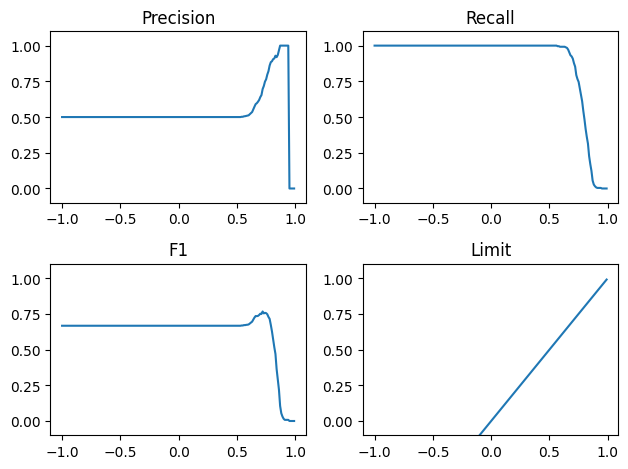

Best F1 0.766 on 0.73
Best Precision 1.000 on 0.95
Best Recall 1.000 on 0.57

Metrics on best F1, limit = 0.73
F1 0.766
Precision 0.717
Recall 0.794

bert-base-multilingual-uncased-extended_corpus.csv


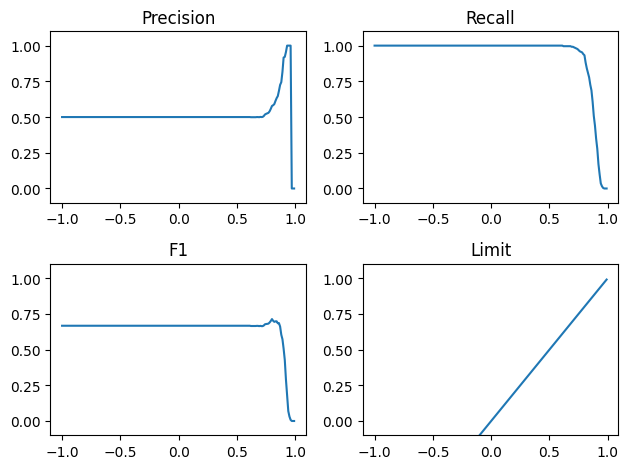

Best F1 0.713 on 0.81
Best Precision 1.000 on 0.97
Best Recall 1.000 on 0.62

Metrics on best F1, limit = 0.81
F1 0.713
Precision 0.583
Recall 0.881

ai-forever_ruBert-large-extended_corpus.csv


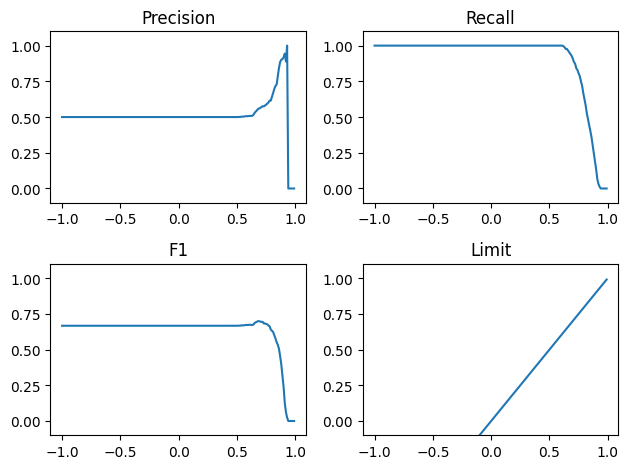

Best F1 0.699 on 0.69
Best Precision 1.000 on 0.94
Best Recall 1.000 on 0.62

Metrics on best F1, limit = 0.69
F1 0.699
Precision 0.560
Recall 0.929



In [36]:
for model_name in bert_models:
    with open(f"{model_name.replace("/", "_")}-{corpus}-embeddings.pickle", "rb") as file:
        res = pickle.load(file)
    X = np.array(res["X"])
    true_answers = np.array(res["true_answers"])
    y = np.array(res["y"])

    preds = []
    for i in range(len(X)):
        preds.append(cosine_similarity([X[i]], [true_answers[i]])[0][0])

    precisions = []
    recalls = []
    f1s = []
    limits = []
    for i in range(20):
        for j in range(10):
            limit = -1 + i / 10 + j / 100
            limits.append(limit)
            limited_preds = np.array([1 if pred > limit else 0 for pred in preds])
            precision = precision_score(y, limited_preds, average="binary", zero_division=0)
            recall = recall_score(y, limited_preds, average="binary", zero_division=0)
            f1 = f1_score(y, limited_preds, average="binary", zero_division=0)
            precisions.append(precision)
            recalls.append(recall)
            f1s.append(f1)
            
    print(f"{model_name.replace("/", "_")}-{corpus}")
    
    x = limits

    y1 = precisions
    y2 = recalls
    y3 = f1s
    
    figure, axis = plt.subplots(2, 2)
    
    axis[0, 0].plot(x, y1)
    axis[0, 0].set_title("Precision")
    axis[0, 0].set_ylim((-0.1, 1.1))
    
    axis[0, 1].plot(x, y2)
    axis[0, 1].set_title("Recall")
    axis[0, 1].set_ylim((-0.1, 1.1))
    
    axis[1, 0].plot(x, y3)
    axis[1, 0].set_title("F1")
    axis[1, 0].set_ylim((-0.1, 1.1))
    
    axis[1, 1].plot(x, x)
    axis[1, 1].set_title("Limit")
    axis[1, 1].set_ylim((-0.1, 1.1))
    
    figure.tight_layout()
    plt.show()

    max_prec = max(precisions)
    max_rec = max(recalls)
    max_f1 = max(f1s)
    
    prec_lim = limits[len(f1s) - precisions[::-1].index(max_prec)]
    rec_lim = limits[len(f1s) - recalls[::-1].index(max_rec)]
    f1_idx = len(f1s) - f1s[::-1].index(max_f1)
    f1_lim = limits[f1_idx]

    print(f"Best F1 {max_f1:.3f} on {f1_lim:.2f}")
    print(f"Best Precision {max_prec:.3f} on {prec_lim:.2f}")
    print(f"Best Recall {max_rec:.3f} on {rec_lim:.2f}")
    print(f"\nMetrics on best F1, limit = {f1_lim:.2f}")
    print(f"F1 {max_f1:.3f}\nPrecision {precisions[f1_idx]:.3f}\nRecall {recalls[f1_idx]:.3f}")
    print()